In [1]:
import torch
import torch.nn as nn
import os
# Arrange GPU devices starting from 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

model_name = 'ch3_32_interval_3_240'
_model = torch.load(os.path.join('models', model_name, f"{model_name}.pth"))
_model = _model.to(device)
model = nn.DataParallel(_model).to(device)
model.eval()

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


DataParallel(
  (module): UNet3d(
    (conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): GroupNorm(8, 32, eps=1e-05, affine=True)
        (5): ReLU(inplace=True)
      )
    )
    (enc1): Down(
      (encoder): Sequential(
        (0): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): GroupNorm(8, 64, eps=1e-05, affine=True)
            (2): ReLU(inplace=True)
            (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (4): GroupNorm(8, 64, eps=1e-05, affine=True)

In [2]:
import json
with open('models/model_subscriptions.json','r') as f:
    models_info = json.load(f)
model_info = next((model for model in models_info if model['model_name'] == model_name), None)
model_info

{'model_name': 'ch3_32_interval_3_240',
 'depth / in_channel / n_channel': [52, 3, 32],
 'img_size': 240,
 'used_channel': ['-t1n.nii.gz', '-t1c.nii.gz', '-t2f.nii.gz'],
 'val score(dice/jaccard)': [88, 81],
 'batch/total epoch/best epoch': [1, 50, 33],
 'resize_info': [0, 155, 3],
 'run time(m)': 1360.0}

In [3]:
from utils import get_dataloader
from dataset import BratsDataset

test_dataloader = get_dataloader(dataset=BratsDataset, phase="test", resize_info=model_info['resize_info'], img_width=model_info['img_size'], data_type=model_info['used_channel'], batch_size=1)

In [4]:
import torch.nn.functional as F
with torch.no_grad():
    tb = next(iter(test_dataloader))
    img = tb['image']
    logits = model(img)
    print(logits.shape)
    logits = F.interpolate(logits, size=(155, 240, 240), mode='trilinear', align_corners=False)
    print(logits.shape)
    probabilities = torch.sigmoid(logits)
    print(probabilities.shape)

Used!
torch.Size([1, 3, 155, 240, 240])
torch.Size([1, 3, 155, 240, 240])
torch.Size([1, 3, 155, 240, 240])


In [5]:
logits.shape

torch.Size([1, 3, 155, 240, 240])

In [10]:
import numpy as np
from utils import dice_coef_metric_per_classes
targets = tb['mask']
probabilities = probabilities.detach().cpu().numpy()
targets = targets.detach().cpu().numpy()
# len(np.unique(probabilities.detach().cpu().numpy()))
dice_coef_metric_per_classes(probabilities, targets)

{'WT': [0.8776035391747756],
 'TC': [0.8204739722310218],
 'ET': [0.5345065996230045]}

In [5]:
import torch
import gc 
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
gc.collect()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predictions = []
total_targets = []
# Counter to keep track of the number of entries processed
counter = 0  

with torch.no_grad():
    for data in tqdm(test_dataloader):
        # if counter >= 15:
        #     break  # Stop processing entries if the desired number is reached

        images, targets = data['image'], data['mask']
        images = images.to(device)
        targets = targets.to(device)

        logits = model(images)
        probabilities = torch.sigmoid(logits)
        prediction = (probabilities >= 0.33).float()

        prediction = prediction.cpu()
        targets = targets.cpu()
        total_targets.append(targets)
        predictions.append(prediction)

        model.zero_grad()
        del images, targets, logits, probabilities, prediction
        torch.cuda.empty_cache()

        counter += 1

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


In [ ]:
len(predictions)

63

In [7]:
np.unique(predictions[0], return_counts=True)

(array([0., 1.], dtype=float32), array([8900399,   85201]))

In [ ]:
# Compute confusion matrix
y_true = np.concatenate(total_targets)
y_pred = np.concatenate(predictions)

y_true.shape, y_pred.shape

((125, 3, 52, 240, 240), (125, 3, 52, 240, 240))

In [ ]:
from utils import dice_coef_metric_per_classes, jaccard_coef_metric_per_classes
def compute_scores_per_classes(model,          # nodel which is UNeT3D 
                               dataloader,     # tuple consisting of ( id , image tensor , mask tensor )
                               classes):       # classes : WT , TC , ET 
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            # Now finding the overlap between the raw prediction i.e. logit & the mask i.e. target & finding the dice & iou scores 
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            # storing both dice & iou scores in the list declared 
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes 

In [ ]:
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, test_dataloader, ['WT', 'TC', 'ET']
    )

In [ ]:
import pandas as pd
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
# CONCAT BOTH THE COLUMNS ALONG AXIS 1 & SORT THE TWO 
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
50,0.902487,0.822301,0.471757,0.308692,0.741067,0.588646
1,0.972105,0.945725,0.965154,0.932655,0.937371,0.882125
61,0.938689,0.884462,0.827312,0.705484,0.885262,0.794144
11,0.936803,0.881119,0.975281,0.951754,0.920201,0.852197
63,0.917244,0.847138,0.935918,0.879554,0.899931,0.818069


In [ ]:
[i for i in val_metics_df.std()]

[0.08102320928692186,
 0.1186816837905717,
 0.18392120628605543,
 0.21168006647283982,
 0.2514333835202592,
 0.24650284766211553]

In [ ]:
val_metics_df.mean()

WT dice       0.900997
WT jaccard    0.828460
TC dice       0.836905
TC jaccard    0.752103
ET dice       0.768334
ET jaccard    0.672939
dtype: float64

In [ ]:
val_metics_df.to_excel('./check.xlsx')

/tmp/ipykernel_71240/3477020508.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
/tmp/ipykernel_71240/3477020508.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)


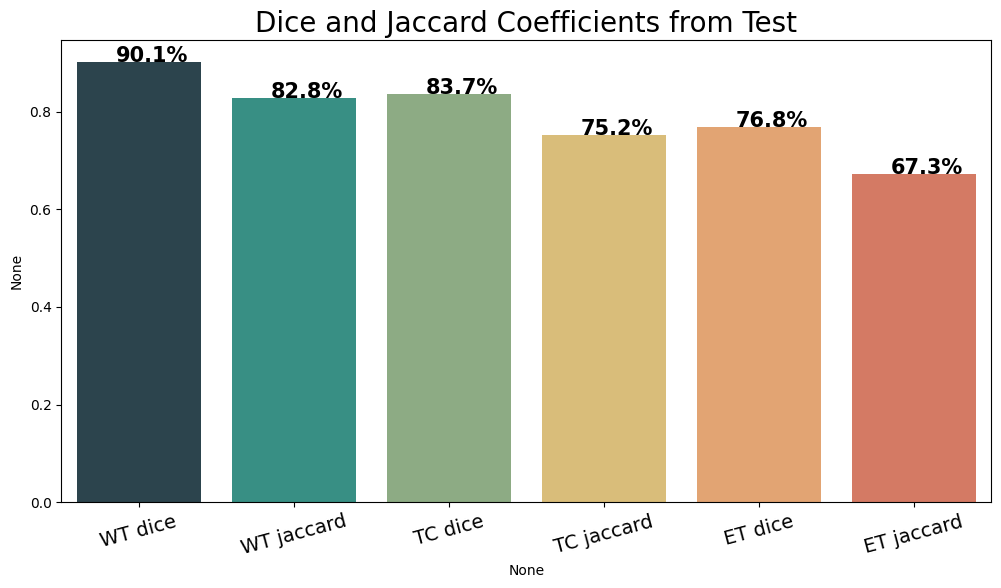

In [ ]:
import seaborn as sns

colors = ['#264653', '#2a9d8f', '#8ab17d', '#e9c46a', '#f4a261', '#e76f51']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)
ax.set_title("Dice and Jaccard Coefficients from Test", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

# fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
# fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')